In [ ]:
#|hide
import math
from fastai.vision.all import *
from FastFF.activations import *
from FastFF.performance import *
import wandb
from fastai.callback.wandb import *

In [ ]:
#|export
import torch
import torch.nn as nn, torch.nn.functional as F 
from FastFF.models.moe import *
from fastcore.all import *

In [ ]:
#|default_exp models.hypercube

In [ ]:
#|export

def binary(x, bits):
    mask = 2**torch.arange(bits, device=x.device, dtype=x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).byte()

class HyperCubeMoE(nn.Module):
    '''Mixture of experts network'''
    def __init__(self, in_dim, out_dim, gate_dim=2, top_k=2, hidden_dim=128, act=nn.ReLU, save_probs=True):
        super().__init__()
        store_attr()
        self.gate = lin(in_dim, gate_dim, act=act, bias=False)
        self.experts = Experts(mlp(in_dim,out_dim, hidden_dim, act=act) for _ in range(2**gate_dim))
        self.mask = binary(torch.arange(0,2**gate_dim), gate_dim)*2-1.
    
    def forward(self,x):
        logits = self.gate(x)
        # probs = F.logsigmoid(logits[:,None,:]*self.mask).sum(-1).exp()
        probs = F.softmax((logits[:,None,:]*self.mask).sum(-1),1)
        if self.save_probs: self.probs = probs
        probs, selected_exps = torch.topk(probs, self.top_k, dim=-1)
        probs /= probs.sum(dim=-1, keepdim=True)
        return self.experts(x, probs, selected_exps)

In [ ]:
#|hide
#|eval: false
h = 32
n = 3
topk=2**n
bs = 256

model = HyperCubeMoE(28*28, 10, n, topk, hidden_dim=h)
cbs = [ProbsDistrCB(), GetGradCB([model.gate[0], *map(lambda x: x[0], model.experts)])]
Learner(get_mnist_dls(bs), model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(10, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.317606,0.225518,0.931600,00:27
1,0.188602,0.158926,0.954100,00:29
2,0.135006,0.148578,0.955600,00:27
3,0.093528,0.100624,0.969100,00:26
4,0.074921,0.099748,0.968900,00:27
5,0.051716,0.084290,0.975800,00:26
6,0.028293,0.075678,0.977400,00:28
7,0.017845,0.070417,0.979900,00:27
8,0.012246,0.067669,0.980200,00:29
9,0.008184,0.067642,0.980700,00:27


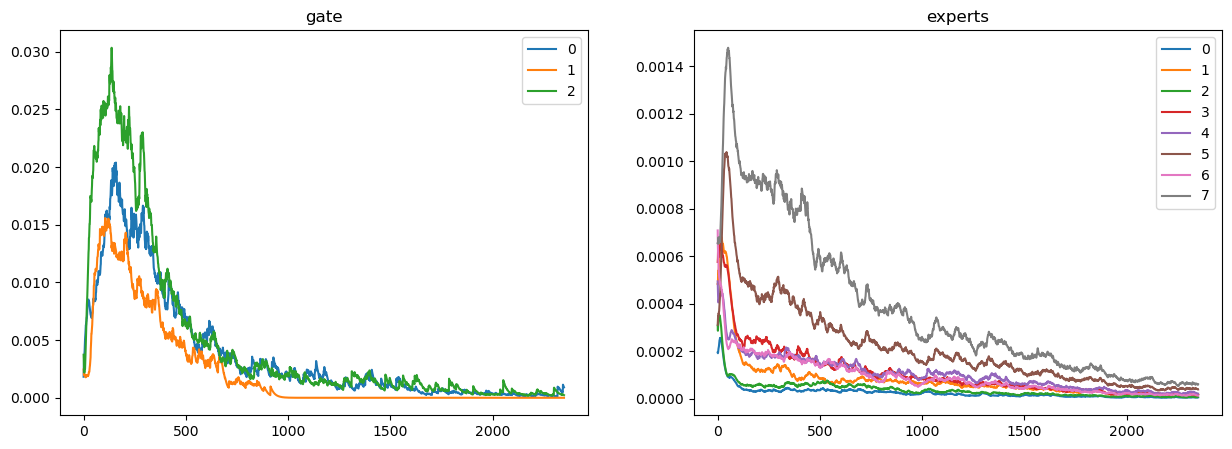

In [ ]:
axes = subplots(figsize=(15,5), ncols=2)[1]
for i, k in enumerate(['gate','experts']): axes[i].title.set_text(k)
cbs[1].show(model.gate[0], lambda x: x.abs().mean(-1), ax=axes[0])
for i, l in enumerate(model.experts): cbs[1].show(l[0], ax=axes[1], label = i)

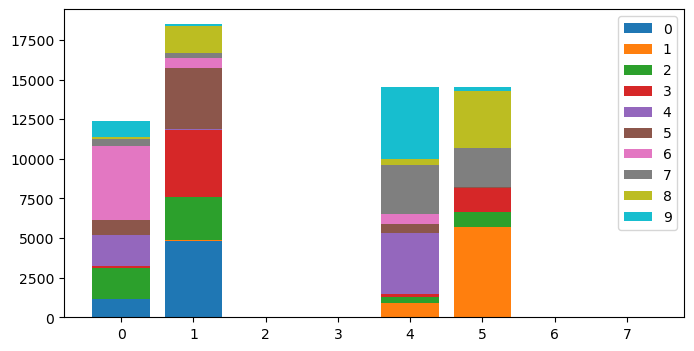

In [ ]:
ax = subplots(figsize=(8,4))[1][0]
cbs[0].show(-1, ax=ax)